In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [3]:
sheets_desc = {"Data": "مشخصات پرسشنامه",
               "P1":"قسمت یکم: خصوصیات اجتماعی اعضای خانوار",
               "P2": "قسمت دوم: مشخصات محل سکونت",
               "P3S01": "قسمت سوم: بخش ۱ هزینه‌های خوراکی خانوار در ماه گذشته",
               "P3S02": "قسمت سوم: بخش ۲ هزینه‌های نوشیدنی‌های طبقه‌بندی نشده و دخانی های خانوار در ماه گذشته",
               "P3S03": "قسمت سوم: بخش ۳ هزینه‌های پوشاک و کفش خانوار در ماه گذشته",
               "P3S04": "قسمت سوم: بخش ۴ هزینه‌های بخش مسکن، آب، فاضلاب، سوخت و روشنایی خانوار در ماه گذشته",
               "P3S05": "قسمت سوم: بخش ۵ هزینه‌های مبلمان و لوازم خانگی",
               "P3S06": "قسمت سوم: بخش ۶ هزینه‌های بهداشتی و درمانی خانوار در ماه گذشته",
               "P3S07": "قسمت سوم: بخش ۷ هزینه‌های حمل و نقل خانوار در ماه گذشته",
               "P3S08": "قسمت سوم: بخش ۸ هزینه‌های ارتباطات خانوار در ماه گذشته",
               "P3S09": "قسمت سوم: بخش ۹ هزینه‌های خدمات فرهنگی و تفریحات خانوار در ماه گذشته",
               "P3S10": "قسمت سوم: بخش ۱۰ هزینه‌های آموزش و تحصیل",  # empty sheet, included in P3S13
               "P3S11": "قسمت سوم: بخش ۱۱ هزینه‌های غذاهای آماده، هتل و رستوران خانوار در ماه گذشته",
               "P3S12": "قسمت سوم: بخش ۱۲ هزینه‌های کالاها و خدمات متفرقه خانوار در ماه گذشته",
               "P3S13": "قسمت سوم: بخش ۱۳ سایر هزینه‌ها و انتقالات در ۱۲ ماه گذشته",
               "P3S14": "قسمت سوم: بخش ۱۴ سرمایه‌گذاری خانوار در ۱۲ ماه گذشته",
               "P4S01": "قسمت چهارم: بخش ۱ درآمد پولی اعضای شاغل خانوار از مشاغل مزد و حقوق بگیری",
               "P4S02": "قسمت چهارم: بخش ۲ درآمد پولی اعضای شاغل خانوار از مشاغل غیر مزد و حقوق بگیری (آزاد)",
               "P4S03": "قسمت چهارم: بخش ۳ درآمدهای متفرقه خانوار در ۱۲ ماه گذشته",
               "P4S04": "قسمت چهارم: ستون ۹ بخش ۳ شامل وام و یارانه"
               }

In [4]:
sheet_indices = [0,3,4,5,6,7,8,9,10,11,13,14,15,17,18,19,20]

In [5]:
resource_directory = "/content/drive/MyDrive/ai-delta/data.zip (Unzipped Files)"
resource_files : list[str] = []
for f in os.listdir(resource_directory):
    f_path = os.path.join(resource_directory, f)
    if os.path.isfile(f_path):
        resource_files.append(f)
del f, f_path

In [6]:
def empty_string_remover(df):
    for col in df.columns:
    # Checking if string dtype
        if is_string_dtype(df[col]):
            # replace cells with only empty strings with np.nan
            df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)
    return df

In [7]:
dfs = []

for filename in resource_files:

    file_path = os.path.join(resource_directory, filename)
    year_file = pd.ExcelFile(file_path)

    if filename.startswith("U"):
        Urban = True
    else:
        Urban = False

    year = int(filename.strip(".xlsx")[1:])
    if (year==99) or (year ==98):
        year = 1300+year

    for sheet_index in sheet_indices:

        sheet_name = list(sheets_desc.keys())[sheet_index]
        print(f"Sheet name from sheets_desc dict: {sheet_name}.",
            f"Sheet name from file: {year_file.sheet_names[sheet_index]}\n",
            f"Loaded sheet description: {sheets_desc[sheet_name]}")

        if sheet_index==0:
            current_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            current_df = empty_string_remover(current_df)
            # Here we add year and Urban columns to the Data (first sheet) dataframe
            current_df["Urban"] = Urban
            current_df["Year"] = year
            # Drop rows that:
                # TakmilDescA is not being nan, these only exist in year 1401.
                # TakmilDescB or JaygozinDescA or JaygozinDescB or JaygozinDescC is not nan,
                # Jaygozin ==2,
                # However, JaygozinDescC does not appear to have a specific definition.
                # Because all the above mean the end of survey for that family.

            current_df = current_df.loc[current_df.TakmilDescA.isna() |
                                    current_df.TakmilDescB.isna() |
                                    current_df.JaygozinDescA.isna() |
                                    current_df.JaygozinDescB.isna() |
                                    current_df.Jaygozin!=2, :]
            if "JaygozinDescC" in current_df.columns:
                current_df = current_df.loc[current_df.JaygozinDescC.isna(), :]
            year_df = current_df.loc[:, ["Address", "Urban", "Year", "khanevartype", "province", "town"]].copy()
            del current_df


        if sheet_index==3:
            food_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            food_cost_df = (empty_string_remover(food_cost_df ).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "food_cost"})
                                .reset_index())

            year_df = pd.merge(year_df, food_cost_df , how="left", on="Address")
            del food_cost_df

        if sheet_index==4:
            drink_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            drink_cost_df  = (empty_string_remover( drink_cost_df ).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "drink_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, drink_cost_df , how="left", on="Address")
            del drink_cost_df


        if sheet_index==5:
            cloth_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            cloth_cost_df  = (empty_string_remover( cloth_cost_df).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "cloth_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, cloth_cost_df, how="left", on="Address")
            del cloth_cost_df

        if sheet_index==6:
            housing_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            housing_cost_df  = (empty_string_remover(housing_cost_df ).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "housing_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, housing_cost_df  ,how="left", on="Address")
            del housing_cost_df


        if sheet_index==7:
            furniture_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            furniture_cost_df  = (empty_string_remover(furniture_cost_df).groupby("Address")
                                .agg({"value": "sum"})
                                 .rename(columns={"value": "furniture_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, furniture_cost_df , how="left", on="Address")
            del furniture_cost_df

        if sheet_index==8:
            health_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            health_cost_df =health_cost_df .multiply(12)
            health_cost_df = (empty_string_remover(health_cost_df).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "health_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, health_cost_df, how="left", on="Address")
            del health_cost_df

        if sheet_index==9:
            transport_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            transport_cost_df = (empty_string_remover(transport_cost_df ).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "transport_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, transport_cost_df , how="left", on="Address")
            del transport_cost_df


        if sheet_index==10:
            communication_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            communication_cost_df= (empty_string_remover(communication_cost_df ).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "communication_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, communication_cost_df , how="left", on="Address")
            del communication_cost_df

        if sheet_index==11:
            entertainment_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            entertainment_cost_df= (empty_string_remover(entertainment_cost_df ).groupby("Address")
                                .agg({"value": "sum"})
                                 .rename(columns={"value": "entertainment_cost"})
                                .reset_index())
            year_df = pd.merge(year_df, entertainment_cost_df, how="left", on="Address")
            del entertainment_cost_df

        if sheet_index==13:
            fastfood_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            fastfood_cost_df= (empty_string_remover(fastfood_cost_df).groupby("Address")
                                .agg({"value": "sum"})
                                 .rename(columns={"value": "fastfood_cost"})
                                .reset_index())
            year_df = pd.merge(year_df,  fastfood_cost_df, how="left", on="Address")
            del  fastfood_cost_df


        if sheet_index==14:
            goods_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            goods_cost_df= (empty_string_remover(   goods_cost_df).groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "goods_cost"})
                                .reset_index())
            year_df = pd.merge(year_df,  goods_cost_df, how="left", on="Address")
            del  goods_cost_df


        if sheet_index==15:
            sayer_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            sayer_cost_df .value = pd.to_numeric( sayer_cost_df.value, errors='coerce').fillna(0).astype("int64")
            sayer_cost_df= (sayer_cost_df.groupby("Address")
                                .agg({"value": "sum"})
                                .rename(columns={"value": "sayer_cost"})
                                .reset_index())
            year_df = pd.merge(year_df,  sayer_cost_df, how="left", on="Address")
            del   sayer_cost_df


          # if sheet_index==16:
          #    sayer_cost_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
          #     sayer_cost_df= (empty_string_remover( sayer_cost_df).groupby("Address")
          #                       .agg({"value": "sum"})
          #                       .reset_index())
          #    year_df = pd.merge(year_df,  sayer_cost_df, how="left", on="Address")
          #    del   sayer_cost_df

        if sheet_index==17:
            income_wage_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_wage_df = (empty_string_remover(income_wage_df).groupby("Address")
                                .agg({"netincome_w_y": "sum"})
                                .reset_index())
            year_df = pd.merge(year_df, income_wage_df, how="left", on="Address")
            del income_wage_df

        if sheet_index==18:
            #Calculating azad income
            income_azad_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            income_azad_df = empty_string_remover(income_azad_df).groupby("Address").agg({"income_s_y": "sum"}).reset_index()
            year_df = pd.merge(year_df, income_azad_df, how="left", on="Address")
            del income_azad_df

        if sheet_index==19:
            # Calculating miscellaneous income
            income_misc_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            # income_misc_df = empty_string_remover(income_misc_df).fillna(0)
            income_misc_df=income_misc_df .apply(pd.to_numeric, errors='coerce').astype('Int64')
            income_misc_df = income_misc_df.groupby("Address").agg({"income_pension": "sum",
                                                        "income_rent": "sum",
                                                        "income_interest": "sum",
                                                        "income_aid": "sum",
                                                        "income_resale": "sum",
                                                        "income_transfer": "sum",
                                                        }).sum(axis=1).to_frame(name='misc_income').reset_index()
            year_df = pd.merge(year_df, income_misc_df, how="left", on="Address")
            del income_misc_df

        if sheet_index==20:
            #Calculatin subsidy income
            income_subsidy_df = pd.read_excel(year_file, year_file.sheet_names[sheet_index])
            # income_subsidy_df = empty_string_remover(income_subsidy_df).fillna(0).astype("int64")
            income_subsidy_df=income_subsidy_df .apply(pd.to_numeric, errors='coerce').astype('Int64')
            income_subsidy_df = income_subsidy_df.groupby("Address").agg({"subsidy":"sum"}).reset_index()
            year_df = pd.merge(year_df, income_subsidy_df, how="left", on="Address")
            del income_subsidy_df

    dfs.append(year_df)

Sheet name from sheets_desc dict: Data. Sheet name from file: R1400Data
 Loaded sheet description: مشخصات پرسشنامه
Sheet name from sheets_desc dict: P3S01. Sheet name from file: R1400P3S01
 Loaded sheet description: قسمت سوم: بخش ۱ هزینه‌های خوراکی خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S02. Sheet name from file: R1400P3S02
 Loaded sheet description: قسمت سوم: بخش ۲ هزینه‌های نوشیدنی‌های طبقه‌بندی نشده و دخانی های خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S03. Sheet name from file: R1400P3S03
 Loaded sheet description: قسمت سوم: بخش ۳ هزینه‌های پوشاک و کفش خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S04. Sheet name from file: R1400P3S04
 Loaded sheet description: قسمت سوم: بخش ۴ هزینه‌های بخش مسکن، آب، فاضلاب، سوخت و روشنایی خانوار در ماه گذشته
Sheet name from sheets_desc dict: P3S05. Sheet name from file: R1400P3S05
 Loaded sheet description: قسمت سوم: بخش ۵ هزینه‌های مبلمان و لوازم خانگی
Sheet name from sheets_desc dict: P3S06. Sheet name fr

In [8]:
len(dfs)

8

In [9]:
final_df = pd.concat(dfs, axis=0)

In [10]:
final_df

,Address,Urban,Year,khanevartype,province,town,food_cost,drink_cost,cloth_cost,housing_cost,...,transport_cost,communication_cost,entertainment_cost,fastfood_cost,goods_cost,sayer_cost,netincome_w_y,income_s_y,misc_income,subsidy
0,20001383919,False,1400,1,Markazi,1,14181000.0,NaN,NaN,8110000,...,600000.0,140000.0,NaN,NaN,1150000.0,493421940.0,354000000.0,NaN,158600000.0,23100000
1,20001383923,False,1400,1,Markazi,1,41020000.0,NaN,1500000.0,9000000,...,2800000.0,650000.0,NaN,NaN,2160000.0,52600000.0,NaN,636000000.0,NaN,<NA>
2,20001383925,False,1400,1,Markazi,1,19960000.0,NaN,NaN,8920000,...,2350000.0,600000.0,NaN,NaN,1750000.0,35457552.0,NaN,173000000.0,42320000.0,17640000
3,20001383929,False,1400,1,Markazi,1,24186000.0,NaN,NaN,3560000,...,3000000.0,1000000.0,NaN,NaN,1860000.0,2028776.0,160000000.0,NaN,23560000.0,6720000
4,20001383932,False,1400,1,Markazi,1,48182000.0,NaN,NaN,9260000,...,2500000.0,290000.0,NaN,NaN,1110000.0,30530000.0,NaN,NaN,416360000.0,10920000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19893,13006383810,True,1398,1,Alborz,6,6101000.0,1500000.0,NaN,12530000,...,350000.0,150000.0,NaN,NaN,150000.0,12120000.0,516000000.0,NaN,NaN,16380000
19894,13006383814,True,1398,1,Alborz,6,7200000.0,NaN,2000000.0,12530000,...,290000.0,270000.0,800000.0,NaN,530000.0,3120000.0,216000000.0,NaN,NaN,10920000
19895,13006383815,True,1398,1,Alborz,6,1216666.0,NaN,NaN,5000000,...,NaN,160000.0,NaN,NaN,NaN,NaN,120000000.0,NaN,NaN,<NA>
19896,13006383820,True,1398,1,Alborz,6,6462750.0,750000.0,NaN,10580000,...,3700000.0,540000.0,NaN,NaN,NaN,26300000.0,NaN,360000000.0,NaN,27300000


In [11]:
print(final_df.dtypes)

Address                 int64
Urban                    bool
Year                    int64
khanevartype            int64
province               object
town                    int64
food_cost             float64
drink_cost            float64
cloth_cost            float64
housing_cost            int64
furniture_cost        float64
health_cost           float64
transport_cost        float64
communication_cost    float64
entertainment_cost    float64
fastfood_cost         float64
goods_cost            float64
sayer_cost            float64
netincome_w_y         float64
income_s_y             object
misc_income           float64
subsidy                 Int64
dtype: object


In [12]:
final_df_1=final_df.drop(['Urban', 'khanevartype','province','town'], axis=1)

In [13]:
print(final_df_1.dtypes)

Address                 int64
Year                    int64
food_cost             float64
drink_cost            float64
cloth_cost            float64
housing_cost            int64
furniture_cost        float64
health_cost           float64
transport_cost        float64
communication_cost    float64
entertainment_cost    float64
fastfood_cost         float64
goods_cost            float64
sayer_cost            float64
netincome_w_y         float64
income_s_y             object
misc_income           float64
subsidy                 Int64
dtype: object


In [14]:
final_df_1.income_s_y  = pd.to_numeric(final_df_1.income_s_y  ,errors='coerce').astype('Int64')
print(final_df_1.dtypes)

Address                 int64
Year                    int64
food_cost             float64
drink_cost            float64
cloth_cost            float64
housing_cost            int64
furniture_cost        float64
health_cost           float64
transport_cost        float64
communication_cost    float64
entertainment_cost    float64
fastfood_cost         float64
goods_cost            float64
sayer_cost            float64
netincome_w_y         float64
income_s_y              Int64
misc_income           float64
subsidy                 Int64
dtype: object


In [15]:
final_df_2=final_df_1.fillna(0).astype("int64")
# final_df_2.sort_values(by=['Year'], ascending=True)


In [16]:
final_df_2['INCOME'] = final_df_2['netincome_w_y'] +final_df_2['income_s_y']+final_df_2['misc_income']+final_df_2['subsidy']

In [17]:
final_df_2['COSTS']= final_df_2['food_cost'].multiply(12)+final_df_2['drink_cost'].multiply(12)+final_df_2['cloth_cost'].multiply(12)+final_df_2['housing_cost'].multiply(12)+final_df_2['furniture_cost']+final_df_2['health_cost'].multiply(12)+final_df_2['transport_cost'].multiply(12)+final_df_2['communication_cost'].multiply(12)+final_df_2['entertainment_cost'].multiply(12)+final_df_2['fastfood_cost'].multiply(12)+final_df_2['goods_cost'].multiply(12)+final_df_2['sayer_cost']

In [18]:
final_df_2

,Address,Year,food_cost,drink_cost,cloth_cost,housing_cost,furniture_cost,health_cost,transport_cost,communication_cost,entertainment_cost,fastfood_cost,goods_cost,sayer_cost,netincome_w_y,income_s_y,misc_income,subsidy,INCOME,COSTS
0,20001383919,1400,14181000,0,0,8110000,2620000,0,600000,140000,0,0,1150000,493421940,354000000,0,158600000,23100000,535700000,786213940
1,20001383923,1400,41020000,0,1500000,9000000,3800000,0,2800000,650000,0,0,2160000,52600000,0,636000000,0,0,636000000,741960000
2,20001383925,1400,19960000,0,0,8920000,3010000,0,2350000,600000,0,0,1750000,35457552,0,173000000,42320000,17640000,232960000,441427552
3,20001383929,1400,24186000,0,0,3560000,1020000,0,3000000,1000000,0,0,1860000,2028776,160000000,0,23560000,6720000,190280000,406320776
4,20001383932,1400,48182000,0,0,9260000,2600000,0,2500000,290000,0,0,1110000,30530000,0,0,416360000,10920000,427280000,769234000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19893,13006383810,1398,6101000,1500000,0,12530000,430000,0,350000,150000,0,0,150000,12120000,516000000,0,0,16380000,532380000,261922000
19894,13006383814,1398,7200000,0,2000000,12530000,1147000,0,290000,270000,800000,0,530000,3120000,216000000,0,0,10920000,226920000,287707000
19895,13006383815,1398,1216666,0,0,5000000,0,0,0,160000,0,0,0,0,120000000,0,0,0,120000000,76519992
19896,13006383820,1398,6462750,750000,0,10580000,350000,0,3700000,540000,0,0,0,26300000,0,360000000,0,27300000,387300000,291043000


In [19]:
print(final_df_2)

           Address  Year  food_cost  drink_cost  cloth_cost  housing_cost  \
0      20001383919  1400   14181000           0           0       8110000   
1      20001383923  1400   41020000           0     1500000       9000000   
2      20001383925  1400   19960000           0           0       8920000   
3      20001383929  1400   24186000           0           0       3560000   
4      20001383932  1400   48182000           0           0       9260000   
...            ...   ...        ...         ...         ...           ...   
19893  13006383810  1398    6101000     1500000           0      12530000   
19894  13006383814  1398    7200000           0     2000000      12530000   
19895  13006383815  1398    1216666           0           0       5000000   
19896  13006383820  1398    6462750      750000           0      10580000   
19897  13006383823  1398    7167000      140000     2020000      10760000   

       furniture_cost  health_cost  transport_cost  communication_cost  \
0

In [28]:
df = pd.DataFrame(final_df_2[['INCOME','COSTS']])

In [29]:
print(df)

          INCOME      COSTS
0      535700000  786213940
1      636000000  741960000
2      232960000  441427552
3      190280000  406320776
4      427280000  769234000
...          ...        ...
19893  532380000  261922000
19894  226920000  287707000
19895  120000000   76519992
19896  387300000  291043000
19897  310000000  303064000

[151824 rows x 2 columns]


In [30]:
sum(df.columns.isna())

0

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [33]:
df_scaled

,INCOME,COSTS
0,-0.004511,0.389612
1,0.171349,0.311442
2,-0.535319,-0.219413
3,-0.610151,-0.281425
4,-0.194609,0.359619
...,...,...
151819,-0.010333,-0.536489
151820,-0.545909,-0.490943
151821,-0.733376,-0.863980
151822,-0.264708,-0.485050


In [42]:
arr = df.to_numpy()

In [53]:
# from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


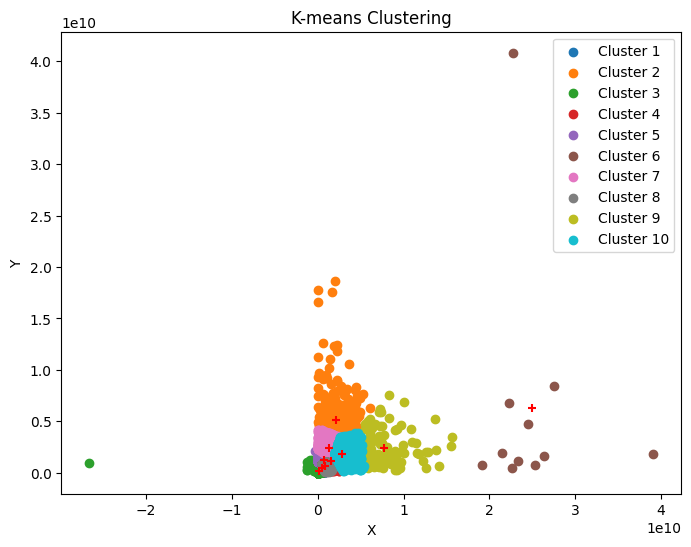

In [45]:
###1

k = 10
kmeans = KMeans(n_clusters=k, random_state=0).fit(arr)
labels = kmeans.labels_

plt.figure(figsize=(8, 6))
for i in range(k):
    cluster_data = arr[labels == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='r', marker='+')
# Add a legend to the plot
plt.legend()
plt.title('K-means Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
# points=[]
# for k in range(1, 20):
#   kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
#   kmeans.fit(df)
#   points.append(kmeans.inertia_)
# plt.plot(range(1, 20), points, marker='o')
# plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

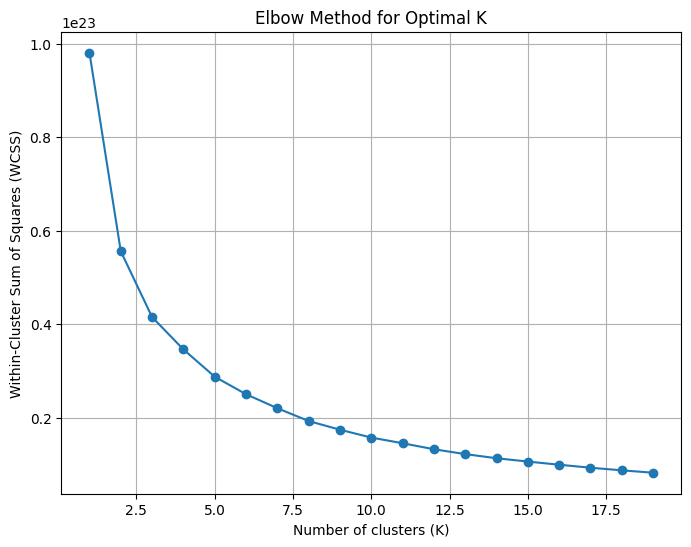

In [50]:
### 2

wcss = []
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(arr)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 20), wcss,marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

In [52]:

kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(arr)

wcss = np.sum(np.min(np.square(arr - kmeans.cluster_centers_[kmeans.labels_]), axis=1))
print("Within-Cluster Sum of Squares:", wcss)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Within-Cluster Sum of Squares: 1.4082816888594492e+21


(array([-1,  0,  1,  2,  3]), array([151812,      3,      3,      3,      3]))


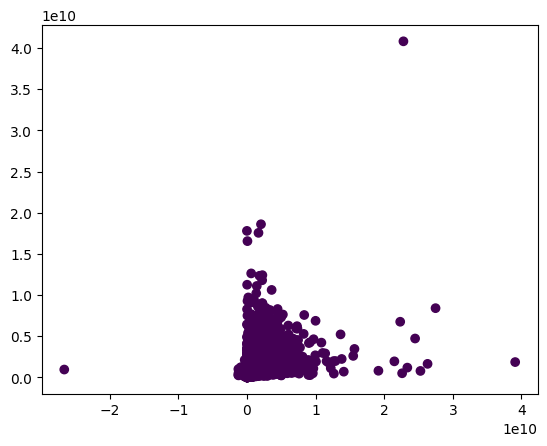

In [55]:
dbscan = DBSCAN(eps=0.2, min_samples=3)
ls = dbscan.fit_predict(arr)
print(np.unique(ls, return_counts=True))
plt.scatter(arr[:, 0], arr[:, 1], c = ls)
plt.show()

In [56]:
num_samples_total = 1000
cluster_centers = [(3,3), (7,7)]
num_classes = len(cluster_centers)
epsilon = 1.0
min_samples = 13


# Compute DBSCAN
db = DBSCAN(eps=epsilon, min_samples=min_samples).fit(arr)
labels = db.labels_

no_clusters = len(np.unique(labels) )
no_noise = np.sum(np.array(labels) == -1, axis=0)

print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 1
Estimated no. of noise points: 151824
